In [9]:
import tensorflow as tf
import pathlib
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


# ✅ Path to the dataset folder
dataset_path = pathlib.Path("/kaggle/input/pe-kurian-sir2/database")

# ✅ Parameters
batch_size = 32
img_size = (224, 224)

# ✅ Load the entire dataset with categorical labels
full_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels="inferred",           # Automatically infer labels from folder names
    label_mode="binary",         # Use binary labels for 2 classes
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

# ✅ Verify class names
class_names = full_dataset.class_names
print("Class names:", class_names)

# ✅ Split dataset into training and validation sets
dataset_size = len(full_dataset)  # Number of batches
val_size = int(0.2 * dataset_size)  # 20% for validation

# ✅ Split
train_dataset = full_dataset.skip(val_size)
val_dataset = full_dataset.take(val_size)

# ✅ Print dataset sizes
print(f"Training dataset size: {len(train_dataset)} batches")
print(f"Validation dataset size: {len(val_dataset)} batches")

# ✅ Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# ✅ Apply normalization
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# ✅ Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)




def build_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3), 
        include_top=False, 
        weights='imagenet'
    )
    
    # Allow the base model to be trainable
    base_model.trainable = True

    # Freeze the earlier layers of the base model
    # Here, we freeze all layers except the last 10 layers.
    for layer in base_model.layers[:-40]:
        layer.trainable = False

    # Create the model architecture
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        
        tf.keras.layers.Dense(128, activation='relu'),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.FalseNegatives(name='false_negatives'),
            tf.keras.metrics.FalsePositives(name='false_positives'),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
        ]
    )
    
    return model



# ✅ Build the model
model = build_model()
model.summary()

# ✅ Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    batch_size=batch_size
)

# ✅ Evaluate the model
loss, acc, fn, fp, prec, rec = model.evaluate(val_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"False Negatives: {fn}")
print(f"False Positives: {fp}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")

# ✅ Plot accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()



Found 625 files belonging to 2 classes.
Class names: ['NO', 'pen']
Training dataset size: 16 batches
Validation dataset size: 4 batches


KeyboardInterrupt: 

In [ ]:
!pip uninstall jax jaxlib -y


Found 3719 files belonging to 2 classes.
Class names: ['BOTTLE', 'NO']
Training dataset size: 94 batches
Validation dataset size: 23 batches
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         590,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │              

 Total params: 2,230,054 (8.51 MB)

 Trainable params: 2,005,246 (7.65 MB)

 Non-trainable params: 224,808 (878.16 KB)

Epoch 1/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 293ms/step - accuracy: 0.5939 - false_negatives: 628.5684 - false_positives: 0.0000e+00 - loss: 0.6873 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5856 - val_false_negatives: 305.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.6922 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5800 - false_negatives: 642.9895 - false_positives: 0.0000e+00 - loss: 0.6674 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5856 - val_false_negatives: 305.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.6922 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5850 - false_negatives: 633.9474 - false_positives: 0.0000e+00 - loss: 0.6533 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5856 - val_false_negatives: 305.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.6922 -

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)        │ (None, 7, 7, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │         590,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 3)                   │              

 Total params: 2,230,054 (8.51 MB)

 Trainable params: 2,005,246 (7.65 MB)

 Non-trainable params: 224,808 (878.16 KB)

Epoch 1/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 228ms/step - accuracy: 0.4442 - false_negatives: 51.3368 - false_positives: 793.2105 - loss: 0.9868 - precision_1: 0.4316 - recall_1: 0.9251 - val_accuracy: 0.5856 - val_false_negatives: 305.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.6928 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4662 - false_negatives: 63.1684 - false_positives: 757.8105 - loss: 0.7507 - precision_1: 0.4389 - recall_1: 0.9033 - val_accuracy: 0.5856 - val_false_negatives: 305.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.6925 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4607 - false_negatives: 87.9684 - false_positives: 741.7789 - loss: 0.7161 - precision_1: 0.4329 - recall_1: 0.8681 - val_accuracy: 0.5856 - val_false_negatives: 305.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.6922 - val_precisio

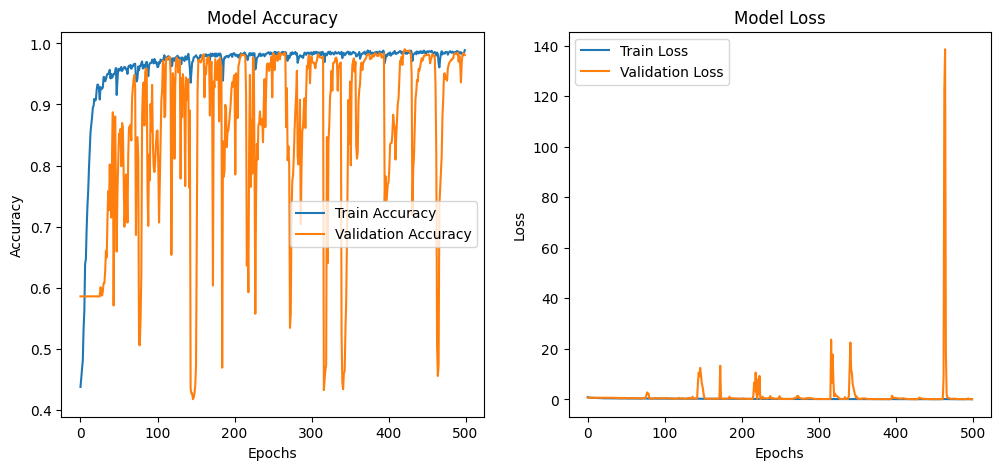

In [1]:
# If you are not using JAX, run this cell to uninstall it:
# !pip uninstall jax jaxlib -y

import tensorflow as tf
import pathlib
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ✅ Path to the dataset folder
dataset_path = pathlib.Path("/kaggle/input/recent/database")

# ✅ Parameters
batch_size = 32
img_size = (224, 224)

# ✅ Load the entire dataset with binary labels for 2 classes
full_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels="inferred",           # Automatically infer labels from folder names
    label_mode="binary",         # Use binary labels for 2 classes
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

# ✅ Verify class names
class_names = full_dataset.class_names
print("Class names:", class_names)

# ✅ Split dataset into training and validation sets
dataset_size = len(full_dataset)  # Number of batches
val_size = int(0.2 * dataset_size)  # 20% for validation

# ✅ Split
train_dataset = full_dataset.skip(val_size)
val_dataset = full_dataset.take(val_size)

# ✅ Print dataset sizes
print(f"Training dataset size: {len(train_dataset)} batches")
print(f"Validation dataset size: {len(val_dataset)} batches")

# ✅ Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# ✅ Apply normalization
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# ✅ Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)


def run_againa_again():
    def build_model():
        base_model = MobileNetV3Small(
            input_shape=(224, 224, 3), 
            include_top=False, 
            weights='imagenet'
        )
        
        # Allow the base model to be trainable
        base_model.trainable = True
    
        # Freeze the earlier layers of the base model (keeping the last 35 layers trainable)
        for layer in base_model.layers[:-40]:
            layer.trainable = False
    
        # Create the model architecture
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(8, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4, activation='relu'),
            tf.keras.layers.Dense(3, activation='relu'),
            tf.keras.layers.Dense(2, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    
        # Compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.FalseNegatives(name='false_negatives'),
                tf.keras.metrics.FalsePositives(name='false_positives'),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall()
            ]
        )
        
        return model
    
    # ✅ Build the model
    model = build_model()
    model.summary()
    
    # ✅ Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=500,
        batch_size=batch_size
    )
    
    # ✅ Evaluate the model
    loss, acc, fn, fp, prec, rec = model.evaluate(val_dataset)
    print(f"Validation Loss: {loss:.4f}")
    print(f"Validation Accuracy: {acc:.4f}")
    print(f"False Negatives: {fn}")
    print(f"False Positives: {fp}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    
    return acc, model, history


# Repeatedly run training until the accuracy exceeds 0.9
while True:
    acc, model, history = run_againa_again()
    
    try:
        if acc > 0.9:
            # ✅ Load and preprocess an image for inference
            img_path = "/kaggle/input/bottle-vs-no/database/BOTTLE/E0.jpg"  # Adjust path if needed
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # ✅ Make prediction
            prediction = model.predict(img_array)[0][0]
            
            # ✅ Define class labels
            class_labels = ["BOTTLE","NO"]
            
            # ✅ Determine predicted class
            predicted_class = class_labels[int(prediction > 0.5)]
            
            # ✅ Print result
            print(f"Predicted Class: {predicted_class}")
            print(f"Confidence Score: {prediction:.4f}")
            break
        else:
            raise Exception("Validation accuracy did not reach the desired threshold.")
    except Exception as e:
        print(f"Accuracy {acc:.4f} did not meet threshold. Retrying... Error: {e}\n\n\n")
    
    print(f"Accuracy {acc:.4f}. \n\n\n")
    if (float(acc) > 0.85):
        break


# ✅ Save the final model
model.save("needed_urgent.h5")
model.save("model.keras", save_format="keras")

# ✅ Plot accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()


In [ ]:
model1.save("This_is_hat_i_wanted.h5")

In [ ]:
import os
print(os.listdir("/kaggle/output/"))


In [ ]:
import shutil

files = os.listdir("/kaggle/output/")
for file in files:
    shutil.move(f"/kaggle/output/{'my_model.h5'}", "/kaggle/working/")
print("Files moved to /kaggle/working/")


In [ ]:
model.save("my_model1.h5")  # Save model


In [ ]:
from tensorflow.keras.models import load_model

# Define a wrapper for layers that used positional args (e.g., Dropout)
def custom_dropout(rate, **kwargs):
    from tensorflow.keras.layers import Dropout
    return Dropout(rate=rate, **kwargs)

# Load the model with custom_objects mapping
model = load_model(
    "/kaggle/working/This_is_hat_i_wanted.h5",
    custom_objects={'Dropout': custom_dropout},
    compile=False
)

In [8]:

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import load_model

# ✅ Load the saved model
model = load_model("/kaggle/input/kerass/keras/default/1/model.keras")

# ✅ Load and preprocess an image
img_path = "/kaggle/input/bottle-vs-no/database/BOTTLE/E1001.jpg"
img = load_img(img_path, target_size=(224, 224))  # Resize to match model input size
img_array = img_to_array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# ✅ Make prediction
predictions = model.predict(img_array)[0][0]  # Extract scalar value from array
predictions1 = model.predict(img_array)
print(predictions1)

# ✅ Define class labels (from your dataset)
class_labels = ["BOTTLE", "NO"]  # Modify based on your class names

# ✅ Determine predicted class
predicted_class = class_labels[int(predictions > 0.5)]  # Threshold for binary classification

# ✅ Print result
print(f"Predicted Class: {predicted_class}")
print(f"Confidence Score: {predictions:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[0.16522361]]
Predicted Class: BOTTLE
Confidence Score: 0.1652
